✅ Datos cargados: (72, 5)


,file,mean,std,min,max
0,Sample_Image_2015-11-27_159.hdf5,93599.997867,13369.081102,75293.0,113008.0
1,Sample_Image_2015-11-27_160.hdf5,92534.432533,13940.058882,73224.0,112266.0
2,Sample_Image_2015-11-27_161.hdf5,93503.821156,13282.563154,75305.0,112768.0
3,Sample_Image_2015-11-27_162.hdf5,92501.441067,13901.262660,73399.0,112271.0
4,Sample_Image_2015-11-27_163.hdf5,93433.300800,13224.325731,75216.0,112445.0


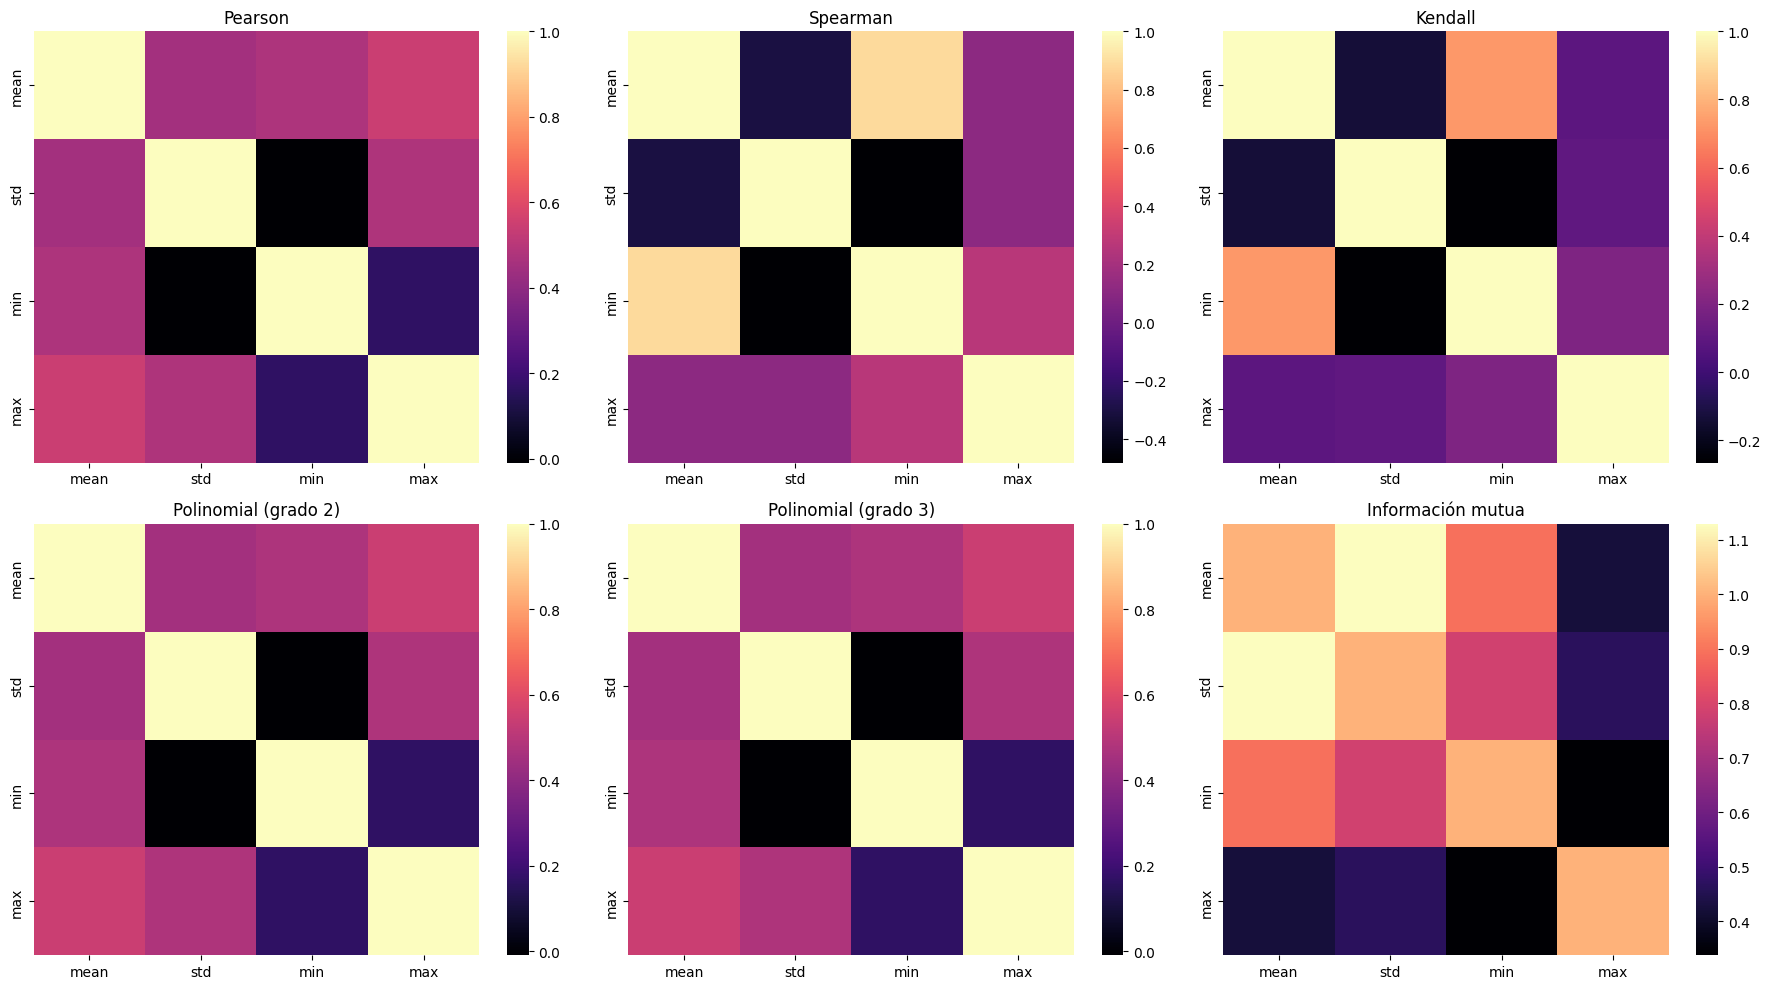

In [ ]:
# =============================================
# 02_xmcd_correlations.ipynb
# Correlaciones avanzadas en el dataset XMCD
# =============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression

# --- 1. Cargar estadísticas ---
stats_path = Path("../notebooks/xmcd_stats.csv")
df_stats = pd.read_csv(stats_path)

print(" Datos cargados:", df_stats.shape)
display(df_stats.head())

numeric_df = df_stats.drop(columns=["file"])
cols = numeric_df.columns

# --- 2. Correlaciones clásicas ---
pearson_corr = numeric_df.corr(method="pearson")
spearman_corr = numeric_df.corr(method="spearman")
kendall_corr = numeric_df.corr(method="kendall")

# --- 3. Correlaciones polinomiales ---
def polynomial_corr(data, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    transformed = poly.fit_transform(data)
    df_poly = pd.DataFrame(transformed, columns=poly.get_feature_names_out(cols))
    return df_poly.corr()

poly2_corr = polynomial_corr(numeric_df, degree=2)
poly3_corr = polynomial_corr(numeric_df, degree=3)

# --- 4. Información mutua ---
mi_matrix = np.zeros((len(cols), len(cols)))
for i, c1 in enumerate(cols):
    for j, c2 in enumerate(cols):
        if i == j:
            mi_matrix[i, j] = 1.0
        else:
            mi = mutual_info_regression(
                numeric_df[[c1]], numeric_df[c2], discrete_features=False
            )
            mi_matrix[i, j] = mi[0]
mi_corr = pd.DataFrame(mi_matrix, index=cols, columns=cols)

# --- 5. Visualización ---
corr_matrices = {
    "Pearson": pearson_corr,
    "Spearman": spearman_corr,
    "Kendall": kendall_corr,
    "Polinomial (grado 2)": poly2_corr.loc[cols, cols],
    "Polinomial (grado 3)": poly3_corr.loc[cols, cols],
    "Información mutua": mi_corr,
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for ax, (name, matrix) in zip(axes, corr_matrices.items()):
    sns.heatmap(matrix, annot=False, cmap="magma", xticklabels=cols, yticklabels=cols, ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()



===== Pearson =====
Media: 0.513
Desviación estándar: 0.331
Mínimo: -0.010
Máximo: 1.000
CSV guardado en ..\figs\correlations\pearson_corr.csv


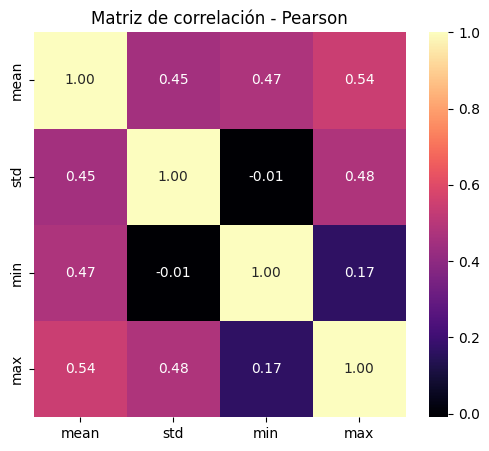

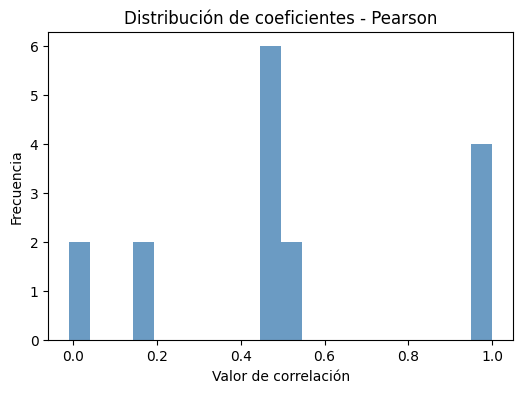


===== Spearman =====
Media: 0.324
Desviación estándar: 0.544
Mínimo: -0.481
Máximo: 1.000
CSV guardado en ..\figs\correlations\spearman_corr.csv


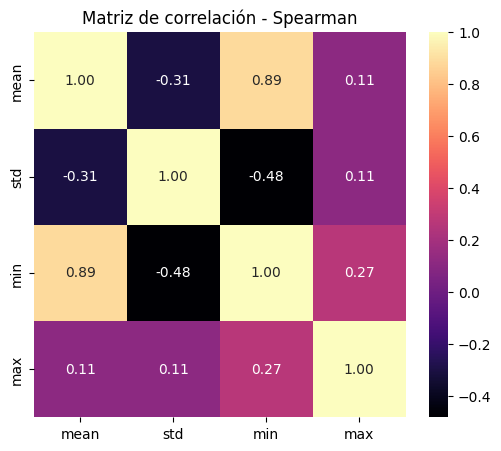

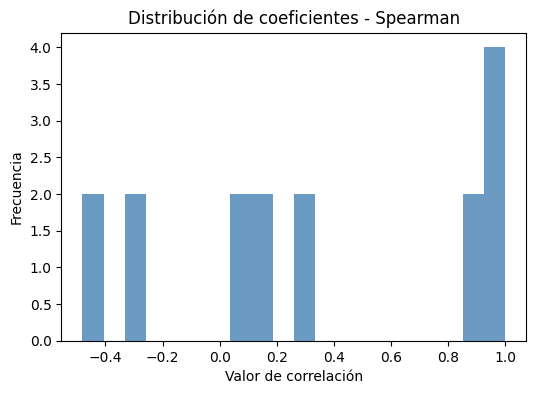


===== Kendall =====
Media: 0.338
Desviación estándar: 0.468
Mínimo: -0.266
Máximo: 1.000
CSV guardado en ..\figs\correlations\kendall_corr.csv


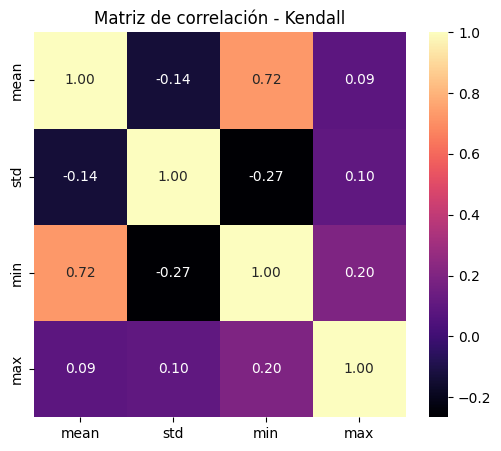

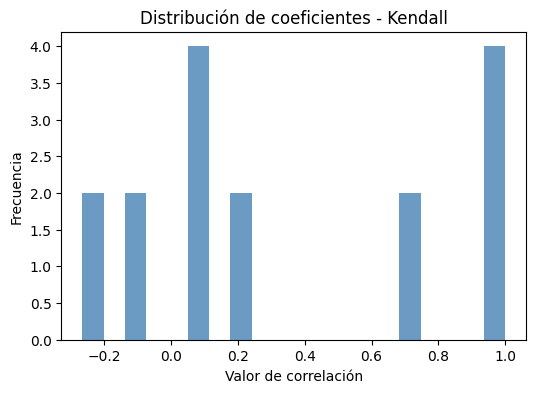


===== Polinomial (grado 2) =====
Media: 0.513
Desviación estándar: 0.331
Mínimo: -0.010
Máximo: 1.000
CSV guardado en ..\figs\correlations\polinomial_(grado_2)_corr.csv


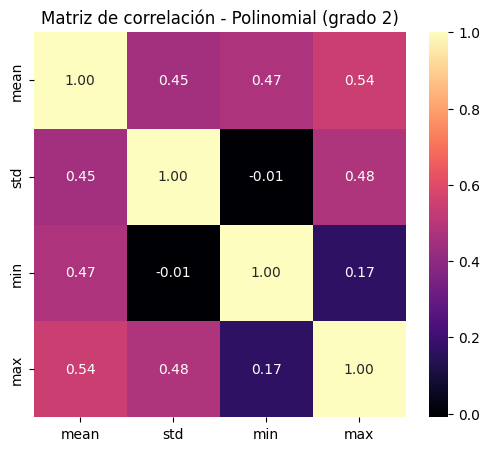

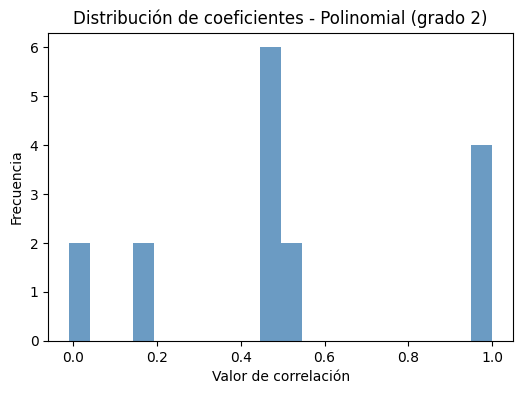


===== Polinomial (grado 3) =====
Media: 0.513
Desviación estándar: 0.331
Mínimo: -0.010
Máximo: 1.000
CSV guardado en ..\figs\correlations\polinomial_(grado_3)_corr.csv


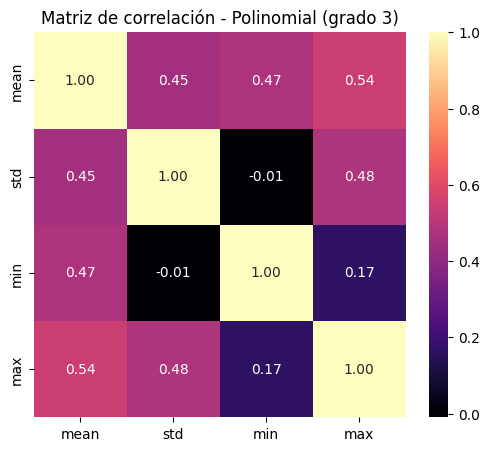

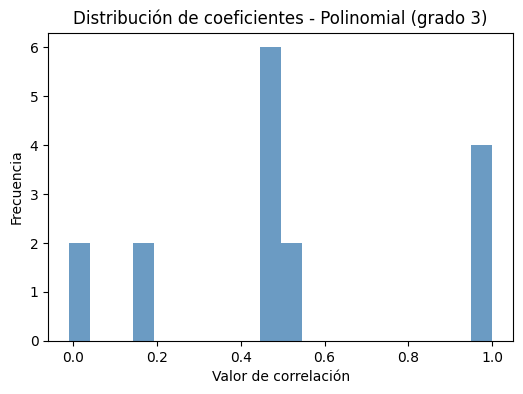


===== Información mutua =====
Media: 0.754
Desviación estándar: 0.285
Mínimo: 0.338
Máximo: 1.129
CSV guardado en ..\figs\correlations\información_mutua_corr.csv


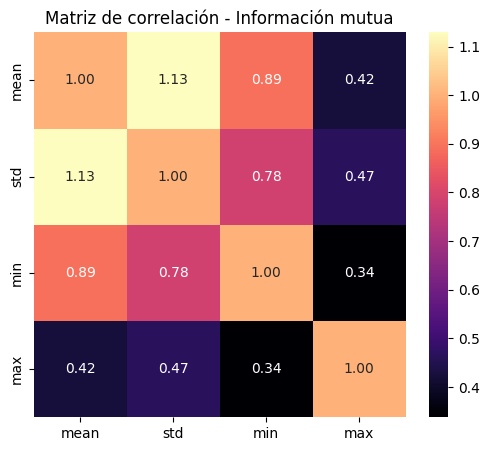

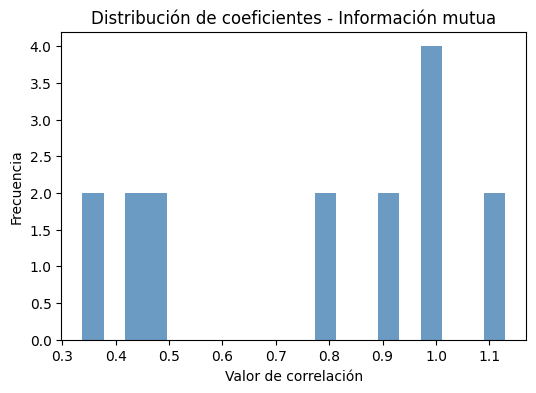

In [ ]:
# =============================================
# Análisis individual de correlaciones
# =============================================

out_dir = Path("../figs/correlations")
out_dir.mkdir(parents=True, exist_ok=True)

def analyze_corr(matrix, name):
    """
    Guarda matriz de correlación en CSV,
    muestra heatmap y estadísticas descriptivas.
    """
    print(f"\n===== {name} =====")

    # --- Estadísticas de la matriz ---
    vals = matrix.values.flatten()
    vals = vals[~np.isnan(vals)]  # quitar NaN si aparecen

    print(f"Media: {np.mean(vals):.3f}")
    print(f"Desviación estándar: {np.std(vals):.3f}")
    print(f"Mínimo: {np.min(vals):.3f}")
    print(f"Máximo: {np.max(vals):.3f}")

    # --- Guardar CSV ---
    csv_path = out_dir / f"{name.replace(' ', '_').lower()}_corr.csv"
    matrix.to_csv(csv_path)
    print(f"CSV guardado en {csv_path}")

    # --- Heatmap ---
    plt.figure(figsize=(6,5))
    sns.heatmap(matrix, annot=True, cmap="magma", xticklabels=cols, yticklabels=cols, fmt=".2f")
    plt.title(f"Matriz de correlación - {name}")
    plt.show()

    # --- Histograma de coeficientes ---
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=20, color="steelblue", alpha=0.8)
    plt.title(f"Distribución de coeficientes - {name}")
    plt.xlabel("Valor de correlación")
    plt.ylabel("Frecuencia")
    plt.show()


# Ejecutar para cada método
for name, matrix in corr_matrices.items():
    analyze_corr(matrix, name)


In [ ]:
# =============================================
# Ranking de pares más correlacionados
# =============================================

def top_correlations(matrix, name, top_n=5):
    """
    Extrae los top_n pares más correlacionados (en valor absoluto)
    de una matriz de correlación.
    """
    print(f"\n🔎 Top {top_n} correlaciones - {name}")

    corr_pairs = (
        matrix.where(~np.eye(matrix.shape[0],dtype=bool))  # eliminar diagonal
              .stack()  # pasar a forma larga
              .reset_index()
    )
    corr_pairs.columns = ["var1", "var2", "corr"]

    # ordenar por valor absoluto
    corr_pairs["abs_corr"] = corr_pairs["corr"].abs()
    top = corr_pairs.sort_values("abs_corr", ascending=False).head(top_n)
    display(top)
    return top


# Ejecutar ranking para cada método
rankings = {}
for name, matrix in corr_matrices.items():
    rankings[name] = top_correlations(matrix, name, top_n=5)



🔎 Top 5 correlaciones - Pearson


,var1,var2,corr,abs_corr
2,mean,max,0.544610,0.544610
9,max,mean,0.544610,0.544610
5,std,max,0.477365,0.477365
10,max,std,0.477365,0.477365
1,mean,min,0.473964,0.473964



🔎 Top 5 correlaciones - Spearman


,var1,var2,corr,abs_corr
1,mean,min,0.887177,0.887177
6,min,mean,0.887177,0.887177
4,std,min,-0.480682,0.480682
7,min,std,-0.480682,0.480682
0,mean,std,-0.305775,0.305775



🔎 Top 5 correlaciones - Kendall


,var1,var2,corr,abs_corr
1,mean,min,0.723288,0.723288
6,min,mean,0.723288,0.723288
4,std,min,-0.266145,0.266145
7,min,std,-0.266145,0.266145
11,max,min,0.195695,0.195695



🔎 Top 5 correlaciones - Polinomial (grado 2)


,var1,var2,corr,abs_corr
2,mean,max,0.544610,0.544610
9,max,mean,0.544610,0.544610
5,std,max,0.477365,0.477365
10,max,std,0.477365,0.477365
1,mean,min,0.473964,0.473964



🔎 Top 5 correlaciones - Polinomial (grado 3)


,var1,var2,corr,abs_corr
2,mean,max,0.544610,0.544610
9,max,mean,0.544610,0.544610
5,std,max,0.477365,0.477365
10,max,std,0.477365,0.477365
1,mean,min,0.473964,0.473964



🔎 Top 5 correlaciones - Información mutua


,var1,var2,corr,abs_corr
0,mean,std,1.129497,1.129497
3,std,mean,1.129497,1.129497
1,mean,min,0.893789,0.893789
6,min,mean,0.893789,0.893789
7,min,std,0.783618,0.783618
